# Where does error come from?

In lecture, we discussed how the source of error comes from one of three places
* **Irreducible Error:** The noise from the dataset. In our model, `y_i = f(x_i) + epsilon_i`, and it is hopeless to learn the `epsilon_i` since its random and does not depend on the input
* **Bias:** How much our expected learned model (expectation is over all possible training sets) differs from the underlying model.
* **Variance:** How dependent the learned model is on the particular dataset it was learned on. If slightly changing the dataset leads to a huge change in learned model, then variance is high.

There is a fundamental tradeoff between bias and variance that depends on how complex your model is. Very simple models (constant functions) have high bias since your true function is usually not constant, but have low variance since they generally don't have the complexity to fit the noise of the specific dataset you got. Very complex models (high degree polynomials) have low bias since you can get a descent approximation of the true function **in expectation**, but have high variance since they have the capabilities of fitting the noise in the data.

This notebook has some code examples to demonstrate how this bias variance tradeoff occurs with different model complexities using synthetic data.

# Are our datasets fixed?

We first start by defining functions to generate synthetic data from some true function `f`. Remember that as machine learning experts, our goal is to learn the parameters for the function `f` (the weights for the polynomial) when we don't have access to the true function. All we get access to is one random training set drawn from the distribution of inputs (some house square footages are more likely than others) with associated values that are from the true function `f` with some added noise.

In [1]:
import math
import random 

import turicreate as tc

# You don't need to know how to use these libraries, they just make code easier to write
import numpy as np
import matplotlib.pyplot as plt

First we define functions to help us generate our data and to generate our features from the inputs. The `generate_data` function will generate `x` values uniformly at random in [0, 1] and then assign the values using the function `f` and Gaussian noise with mean 0 and variance 0.1. 

In [2]:
def f(x):
    """
    True function f(x) (unknown to us)
    """
    return 2 * x - 1.4 * x ** 2


def generate_data(n):
    """
    Creates and returns a SFrame with n randomly drawn examples
    """
    xs = [random.uniform(0, 1) for _ in range(n)]   # generate n numbers uniform at random from [0, 1]
    ys = [f(x) + random.gauss(0, 0.1) for x in xs] # evaluate f at each x and add Gaussian noise (mean=0, variance=.1)
    return tc.SFrame({'x': xs, 'y': ys})


def polynomial_features(data, col, deg):
    """
    Given a dataset, creates a polynomial expansion of the input with 
    the given name to the given degree.
    
    Returns the dataset and the list of column names
    """
    data_copy = data.copy()
    if deg == 0:
        data_copy[col + '0'] = 0
        columns = [col + '0']
    else:
        columns = []
        for i in range(1, deg + 1): # +1 to include deg
            col_name = col + str(i)
            data_copy[col_name] = data_copy[col] ** i
            columns.append(col_name)
        
    return data_copy, columns

Below is an example dataset we might obvserve. 

In [3]:
data = generate_data(15)
data, columns = polynomial_features(data, 'x', 3)
print columns
data

['x1', 'x2', 'x3']


x,y,x1,x2,x3
0.965456186496,0.673184962247,0.965456186496,0.932105648042,0.89990716437
0.33925171336,0.586799151196,0.33925171336,0.115091725018,0.0390450649059
0.642249328449,0.591406436346,0.642249328449,0.412484199894,0.264917700378
0.550551028176,0.793143265582,0.550551028176,0.303106434625,0.16687555923
0.964080485265,0.613866674785,0.964080485265,0.929451182069,0.89606574664
0.452910554595,0.608035392843,0.452910554595,0.205127970464,0.0929046228658
0.440052852927,0.732238948239,0.440052852927,0.193646513369,0.0852147006672
0.979798162556,0.790497632504,0.979798162556,0.960004439348,0.940610585719
0.023278071278,-0.0879068202359,0.023278071278,0.000541868602424,1.26136559505e-05
0.377110874102,0.430799538281,0.377110874102,0.142212611366,0.0536299221805


If you run it multiple times, you would most likely get different values. 

This doesn't seem to happen in real life since we just give you a dataset of houses that never changes, but this idea that the training set is random is important. We want to make sure we are thinking about how our model generalizes to future, probably unseen data so we should keep in mind we could have gotten a different dataset if conditions were slightly different.

The following function will learn some given number of models using random samples from our training set. This is technique of approximating getting new datasets from the underlying distribution with only our one dataset known as bootstrapping. We will use each random sample of our training set to train a model, use the model to predict a range of input values, and look at the range of outputs for each particular input.

In [4]:
def learn_models(data, features, num_models):
    """
    Trains num_models models on random subsets of the given data. 
    Returns the list of learned models.
    """
    models = []
    for i in range(num_models):
        # get a random sample of the datat
        train_data, _ = data.random_split(.5) 
        model = tc.linear_regression.create(train_data, target='y', features=features, verbose=False)
        models.append(model)
    return models


In [5]:
def find_predictions_range(models, model_degree, num_eval_points):
    """
    Compares the predictions of the given models at num_eval_points between 0 and 1.
    
    This gives a description of how spread the predictions are at a particular point x. 
    If the predictions are all over the place, then the range of predictions will be high.
    
    Returns:
        * A list of points evaluated (of length num_eval_points)
        * A list of tuples containing information about the predictions at each eval point. 
          Each tuple contains the minimum prediction, mean prediction, and max prediction for that input
          
    """
    new_xs = np.linspace(0, 1, num_eval_points) # just like range, but allows for fractional steps
    new_data = tc.SFrame({'x': new_xs})
    new_data, _ = polynomial_features(new_data, 'x', model_degree)

    all_predictions = [model.predict(new_data) for model in models]
    intervals = []
    for i in range(len(new_xs)):        
        # get predictions from each model for this input i
        preds_i = [preds[i] for preds in all_predictions]
        # find the mean, min, and max
        intervals.append((min(preds_i), np.mean(preds_i), max(preds_i)))
        
    return new_xs, intervals

In [6]:
def plot(data, new_xs, intervals):
    """
    Plots the data and range of predictions to demonstrate the bias and variance of the model
    """
    # magic to separate list of [(low, mean, high)] to list of lows, list of means, list of highs
    lows, means, highs = zip(*intervals)       
    
    # plot the range bands for predictions
    plt.fill_between(new_xs, lows, highs, facecolor='#E8F8F8', edgecolor='#c3e2e2',
                     label='Range of predictions')
    # plot the average predictions (won't perfectly match f because it's an approximation of E_train[hat{f}]
    plt.plot(new_xs, means, color="r", label='Average hat{f}')
    # plot the true f
    plt.plot(new_xs, [f(x) for x in new_xs], color='g', label='True f')
    # plot the datapoints
    plt.scatter(data['x'], data['y'], c='black', s=10, label='Data')

    # modify axis to make it look nice and add label
    axes = plt.gca()
    axes.set_xlim([0, 1])
    axes.set_ylim([data['y'].min() - 0.5, data['y'].max() + 0.5])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

This is the main function to run our experiments. See the cell aftewards how to call it. 

In [7]:
def bias_variance(num_data, num_models, degree_expansions, num_eval_points=200):
    """
    Demonstrates the bias-variance tradeoff for each degree in degree_expansions using 
    one randomly generated dataset of num_dat samples with value some true f(x) + noise.
    
    For each degree, trains num_models models using features up to that degree. It then uses
    those models to make predictions for the num_eval_points between 0 and 1. It records 
    these predictions and visually plots the range of predictions for each x.
    """
    print 'Generating data'
    data = generate_data(num_data)
    for degree_expansion in degree_expansions:
        print 'Evaluating model with degree ' + str(degree_expansion)
        # generate data with 
        data, columns = polynomial_features(data, 'x', degree_expansion)
        models = learn_models(data, columns, num_models)
        new_xs, intervals = find_predictions_range(models, degree_expansion, num_eval_points)
        plot(data, new_xs, intervals)

Generating data
Evaluating model with degree 0


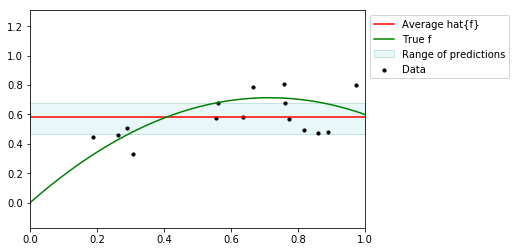

Evaluating model with degree 1


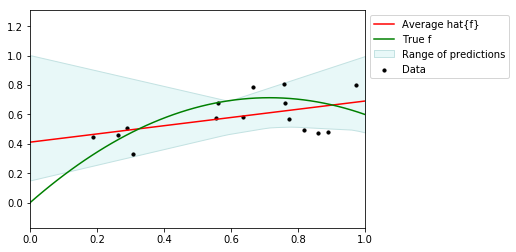

Evaluating model with degree 2


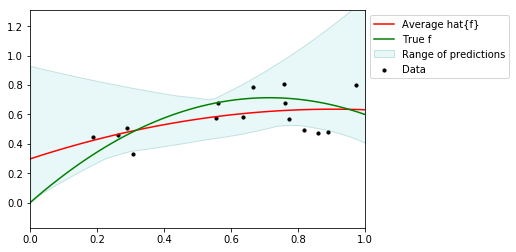

Evaluating model with degree 5


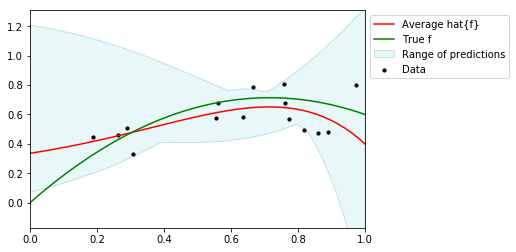

Evaluating model with degree 10


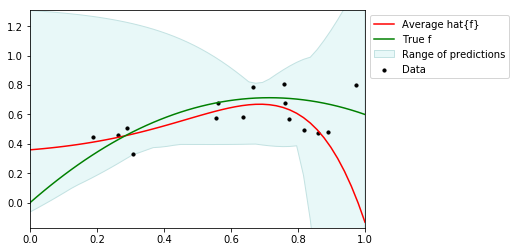

In [13]:
# 15 datapoints
# 100 models
# try degrees [0, 1,2,5,10]
# 50 points used to evaluate the range of predictions
bias_variance(15, 100, [0, 1, 2, 5, 10], 50)

The way to read each of the graphs is:
* The black dots are the datapoints from our one dataset (which was drawn from the underlying distribution)
* The green line is the true function `f`
* The red line is the average prediction at each value x from all of the bootstrapped models. This is an approximation of the expected learned model, but is not perfect since it does not have access to the true distribution of the inputs.
* The blue region is the range of prediction values over all the learned models for that particular input


Notice that with the degree 0 polynomial (constant functions), the range of predictions is relatively small; this means the degree 0 polynomial has low variance. Also notice that it never does a really good job approximating the true function `f` which means it has high bias. 

On the other side of the spectrum, the degree 10 polynomial has very wide ranges of predictions over all the models; this means the high degree model has high variance. Notice that it seems like the average model for this degree polynomial seems to not match the true function like we would expect since it has low bias. This is an artifact of the fact that our original dataset is a small sample from the distribution of inputs so we don't get enough data to make the noise cancel out on different bootstrapped versions of the dataset. If we were using more data and more models estimate the average, we would expect it to go towards the true model in expectation but still maintain its high variance.